# Лабораторная работа 4
## Сети с радиальными базисными элементами
Вариант 3 

Сутдент: Будникова Валерия Павловна 

группа: М8О-407Б-19  

### Цель работы: 
исследование свойств некоторых видов сетей с радиальными базисными элементами, алгоритмов обучения, а также применение сетей в задачах классификации и аппроксимации функции.


### Задание:
1. Использовать вероятностную нейронную сеть для классификации точек в случае, когда классы не являются линейно разделимыми.
2. Использовать сеть с радиальными базисными элементами (RBF) для классификации точек в случае, когда классы не являются линейно разделимыми.
3. Использовать обобщенно-регрессионную нейронную сеть для аппроксимации функции. Проверить работу сети с рыхлыми данными.

### Реализация:

In [21]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import math
import random

In [22]:
class Ellipse:
    def __init__(self, a, b, alph, x0, y0):
        self.a = a
        self.b = b
        self.alph = alph
        self.x0 = x0
        self.y0 = y0
    
    def Get_points(self, t):
        x = self.a * np.cos(t)
        y = self.b * np.sin(t)
        return self.Shift(self.Rotate((x, y)))

    def Rotate(self, points):
        rx = points[0] * np.cos(self.alph) - points[1] * np.sin(self.alph)
        ry = points[0] * np.sin(self.alph) + points[1] * np.cos(self.alph)
        return np.array((rx, ry))
    
    def Shift(self, points):
        return np.array((points[0] + self.x0, points[1] + self.y0))


el1 = Ellipse(0.4,  0.15, math.pi/6, 0, 0)
el2 = Ellipse(0.7,  0.5, math.pi/3, 0, 0)
el3 = Ellipse(1,  1, 0, 0, 0)

t1 = np.arange(0, 2 * math.pi, 0.025)

f_x = lambda t: math.cos(2.5 * t**2  - 5 * t)
t2 = np.arange(0, 2.2, 0.01)

In [23]:
import seaborn as sns
colors = sns.color_palette('turbo', 3)

def Plot(count, points_xy):
    rows = math.ceil(count/3)
    cols = 3 if count > 3 else count
    fig, subplots = plt.subplots(nrows=rows, ncols = cols)
    
    fig.set_figwidth(8 * cols)
    fig.set_figheight(4 * rows)

    colors = sns.color_palette("Set2", len(points_xy[0]))

    for i, ax in enumerate(fig.axes):
        if i < count:
            for j, xy in enumerate(points_xy[i][:-1]):
                try:
                    lbl = xy[2]
                except:
                    lbl = '.'
                ax.plot(xy[0], xy[1], color = colors[j], label = lbl)
                ax.legend()
            ax.set_title(points_xy[i][-1])

def Plot_ellipses(data, labels, ax = None):
    if (ax != None):
        for i, xy in enumerate(data):
            ax.plot(xy[0], xy[1], '.', color = colors[np.argmax(labels[i])])
    else:
        for i, xy in enumerate(data):
            plt.plot(xy[0], xy[1], '.', color = colors[np.argmax(labels[i])])

def Plot_History(history, ep, names):
    count = len(names)

    colors_h = sns.color_palette('cool_r', count)

    rows = math.ceil(count/2)
    cols = 2 if count > 2 else count
    fig, subplots = plt.subplots(nrows=rows, ncols = cols)
    
    fig.set_figwidth(10 * cols)
    fig.set_figheight(4 * rows)
    
    for i, ax in enumerate(fig.axes):
        if i < count:
            ax.plot(range(ep), history.history[names[i]], label = names[i], color= colors_h[i]);
            ax.legend()


# 1

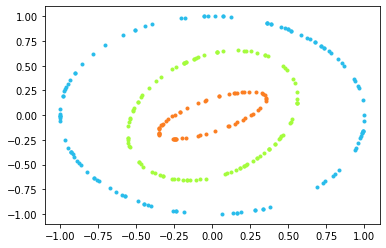

In [24]:
points1 = el1.Get_points(t1)
points2 = el2.Get_points(t1)
points3 = el3.Get_points(t1)

rnd_ind1 = np.random.choice(len(points1.T), 60)
rnd_ind2 = np.random.choice(len(points2.T), 100)
rnd_ind3 = np.random.choice(len(points3.T), 120)

p1 = points1.T[rnd_ind1]
p2 = points2.T[rnd_ind2]
p3 = points3.T[rnd_ind3]

data = np.concatenate((p1, p2, p3), axis=0)

one_hot_labels = np.array([[0, 0, 1]] * 60 +
                          [[0, 1, 0]] * 100 +
                          [[1, 0, 0]] * 120)


Plot_ellipses(data, one_hot_labels)

In [25]:
from sklearn.model_selection import train_test_split
data_train, data_test, label_train, label_test = train_test_split(data, one_hot_labels, test_size=0.3, shuffle=True)

Реализация РБФ слоя:

In [26]:
from keras.layers import Layer
from keras import backend


class RBF_Layer(keras.layers.Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(RBF_Layer, self).__init__(**kwargs)
        
    
    def build(self, input_shape):
        self.mu = self.add_weight(name = 'mu', shape = (input_shape[1], self.output_dim), initializer = 'uniform', trainable = True)
        self.sigma = self.add_weight(name = 'sigma', shape=(self.output_dim,), initializer='random_normal', trainable = True)

        super(RBF_Layer, self).build(input_shape)

    def call(self, inputs):
        global gl_mu
        diff = backend.expand_dims(inputs) - self.mu
        output = backend.exp(backend.sum(diff ** 2, axis = 1) * self.sigma)

        gl_mu = backend.eval(self.mu)
        return output



Создание модели, обучение и построение графиков ошибки и точности

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf__layer_10 (RBF_Layer)   (None, 10)                30        
                                                                 
 dense_20 (Dense)            (None, 3)                 33        
                                                                 
Total params: 63
Trainable params: 63
Non-trainable params: 0
_________________________________________________________________


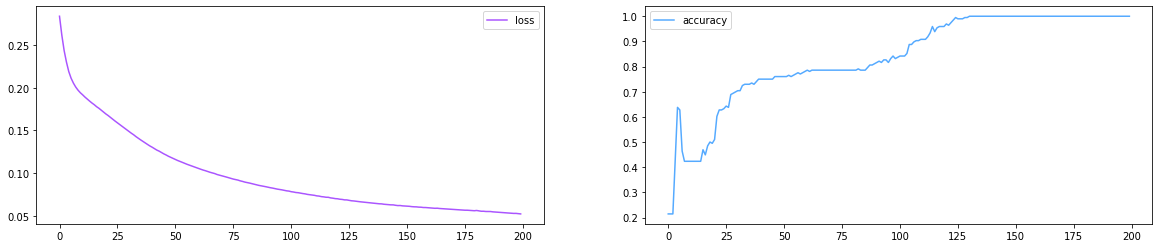

In [44]:
model_1 = keras.models.Sequential()
model_1.add(RBF_Layer(10, input_dim = 2))
model_1.add(keras.layers.Dense(3, activation=keras.activations.sigmoid))

model_1.compile(loss=keras.losses.mean_squared_error, optimizer = keras.optimizers.Adam(0.001), metrics=['accuracy'])

model_1.summary()
ep = 200

history = model_1.fit(data_train, label_train,  batch_size=10, epochs=ep, verbose=0)
Plot_History(history, ep, ['loss', 'accuracy'])

Результат:

313/313 [==============================] - 2s 5ms/step


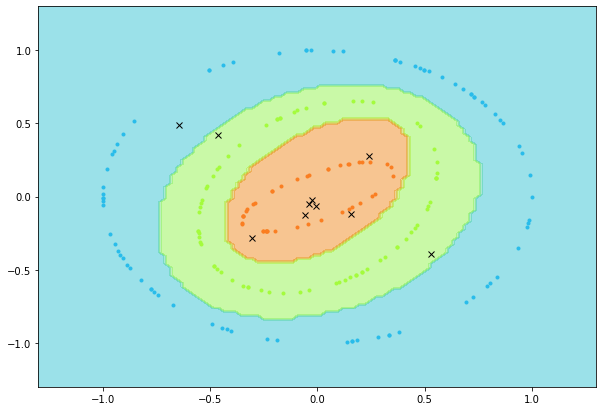

In [45]:
from matplotlib.colors import LinearSegmentedColormap

n = 100
x = np.linspace(-1.3, 1.3, n)
y = np.linspace(-1.3, 1.3, n)

xv, yv = np.meshgrid(x, y)
z = model_1.predict(np.c_[xv.ravel(), yv.ravel()]).argmax(axis=1).reshape(n, n)

cmap = LinearSegmentedColormap.from_list('cmap', colors)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.contourf(xv, yv, z, alpha = 0.5, cmap=cmap)
Plot_ellipses(data_train, label_train, ax)
ax.plot(gl_mu[0], gl_mu[1], 'x', color = 'black')
plt.show()

### 2

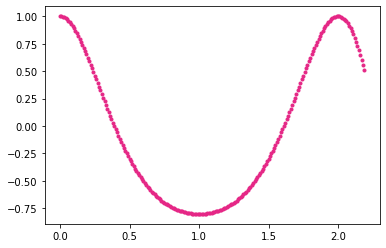

In [29]:
colors_2 = sns.color_palette('PuRd', 10)
data2 = [[i] for i in t2]
labels2 = [[f_x(i)] for i in t2]

plt.plot(data2, labels2, '.', color = colors_2[6]);

In [30]:
data_train2, data_test2, label_train2, label_test2 = train_test_split(data2, labels2, test_size=0.3, shuffle=True)

Создание модели, обучение и построение графиков ошибки и точности

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf__layer_7 (RBF_Layer)    (None, 10)                20        
                                                                 
 dense_15 (Dense)            (None, 80)                880       
                                                                 
 dense_16 (Dense)            (None, 120)               9720      
                                                                 
 dense_17 (Dense)            (None, 1)                 121       
                                                                 
Total params: 10,741
Trainable params: 10,741
Non-trainable params: 0
_________________________________________________________________


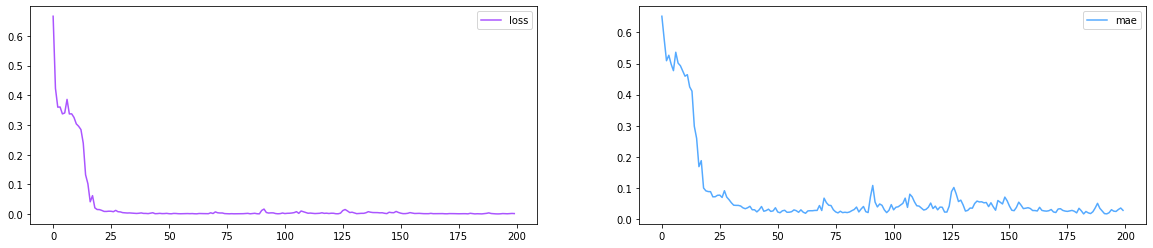

In [31]:
model_2 = keras.models.Sequential()
model_2.add(RBF_Layer(10, input_dim = 1))
model_2.add(keras.layers.Dense(80, input_dim = 1, activation=keras.activations.tanh))
model_2.add(keras.layers.Dense(120, activation=keras.activations.tanh))
model_2.add(keras.layers.Dense(1, activation=keras.activations.linear))

model_2.compile(loss=keras.losses.mean_squared_error, optimizer = keras.optimizers.Adam(0.005), metrics=['mae'])

model_2.summary()

ep2 = 200
history_2 = model_2.fit(data_train2, label_train2,  batch_size=5, epochs=ep2, verbose=0)
Plot_History(history_2, ep2, ['loss', 'mae'])

Результат:

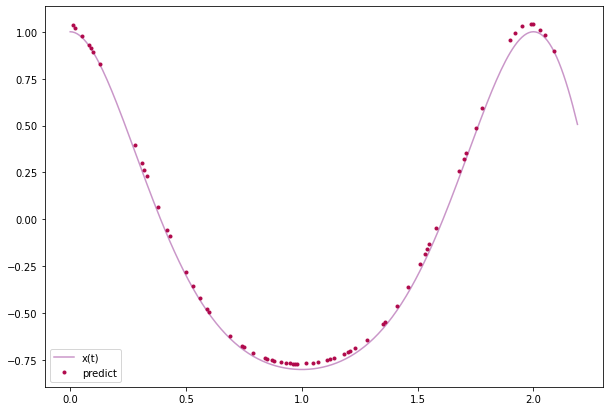

In [40]:
pr2 = model_2.predict(data_test2, verbose = 0)

fig2 = plt.figure(figsize=(10, 7))
ax2 = fig2.add_subplot(111)

ax2.plot(data2, labels2, label = 'x(t)', color = colors_2[3]);
ax2.plot(data_test2, pr2, '.' , label = 'predict', color = colors_2[8]);
ax2.legend();


#### Вывод
В данной лабораторной работе я создала две многослойные сети, с использовнием RBF-слоя для классификации точек и для аппрокчитации функции. Также представлены графики функции ошибки и метрик при обучении сетей.